 ## Q7 Most popular tweets:

    - Most popular tweets means here is the tweet which has been re-tweeted maximum number of times.
    - Get top 100 most re-tweeted tweets in last 1 hour related to “iphone”.



In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn # For plotting
import time
import json

from IPython import display  # To work with graphs on jupyter
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple #function for creating tuple subclasses with named fields

In [2]:
# magic function to plot inline
%matplotlib inline

In [3]:
if __name__ == "__main__":

    sc = SparkContext(appName="TwitterRetweet")
    ssc = StreamingContext(sc, 60 * 60)  # Setting 1hr interval
    sqlContext = SQLContext(sc)  # Sql context for running sql query
 
    # Host port of server which is sending text stream
    host = "localhost"
    port = 8600
    socketStream = ssc.socketTextStream(host, port) # Connecting to socket
    dStream = socketStream.window(60 * 60)  # Setting 1hr window
    
    def parseTweet(dStream): # Data Manupulation
        try:
            data = json.loads(dStream)  # Load the json data
            return [( # Tuple of name and follower count
                     data.get("name", "undefined").decode("utf-8"), 1
                    )]
        except:
            return []
         
    fields = ("name", "count")
    Tweet = namedtuple('Tweet', fields)
    # DStream where all the computation is done
    (dStream.flatMap(parseTweet)\
            .reduceByKey(lambda a, b: a + b)\
            .map(lambda rec: Tweet(rec[0], rec[1]))\
            .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))\
                          .limit(50).registerTempTable("tweets")))
        
    ssc.start()
#    ssc.awaitTermination()

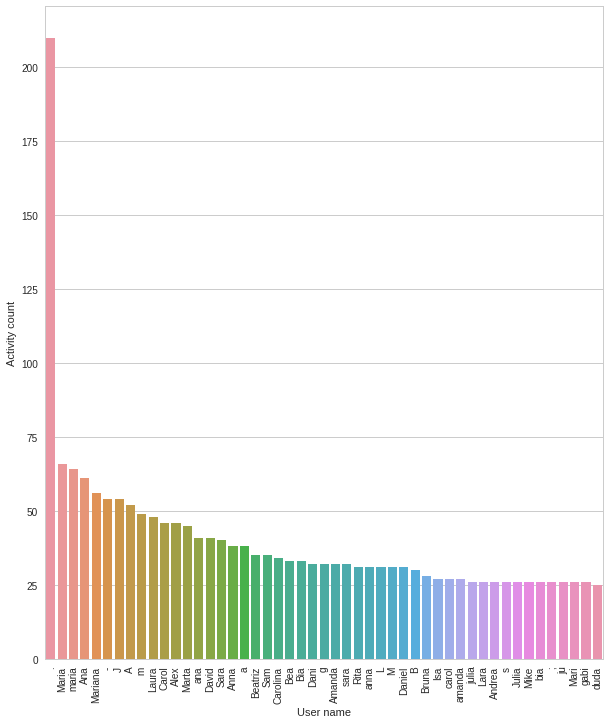

Stoping the program


In [4]:
while True:  # Display graph here
    try:
        time.sleep(60 * 60)  # Sleep 1hr, plot graph every hour
        # Pick all names except undefined because I introduced it
        topics = sqlContext.sql('Select name, count from tweets where name != "undefined"')
        topics = topics.toPandas()
        display.clear_output(wait=True)
        sn.set_style("whitegrid")  # Styling of plot
        sn.plt.figure(figsize = (10, 12)) # Figuresize of plot
        ax = sn.barplot(x="name", y="count", data=topics, estimator=sum)
        ax.set(xlabel='User name', ylabel='Activity count') # Labeling of plot
        for item in ax.get_xticklabels():  # rotate labels as it wont be vizible else
            item.set_rotation(90)
        sn.plt.show()
    except KeyboardInterrupt:  # User interrupt
        ssc.stop()
        print("Stoping the program")
        break
    # Continue even if there is exception and stop only on Keyboard Interrupt
    except Exception as e:  
        print(e)
        continue